# PyTorch, EMNIST

# Подготовка модели распознавания рукописных букв и цифр

# План исследований:

## 1. - Подготовка отраженных и перевернутых данных с нормализацией

* Обучение и дообучение модели с сохранением промежуточных результатов: 

 - 10 эпох, lr=0.001

 - 15 эпох, lr=0.0005

 - 5 эпох, lr=0.00001



## 2. - Подготовка отраженных и перевернутых данных с нормализацией

     с использованием методов Eroding, Dilating и Smoothing Images

* Обучение и дообучение модели с сохранением промежуточных результатов:

 - 10 эпох, lr=0.001

 - 15 эпох, lr=0.0005

 - 5 эпох, lr=0.00001


## 3. - Оценка модели

 - Предварительная оценка модели

 - Оценка модели на разных типах данных
 

## 4. - Резульаты и выводы о проделанной работе

# Библиотеки

In [2]:
import os
import torch
import torchvision
from torchvision.datasets import EMNIST
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import cv2
from PIL import Image
from torchinfo import summary

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

# Получение, трансформация, нормализация и контроль данных

In [3]:
# Определение трансформаций для нормализации данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Нормализация по среднему и стандартному отклонению
])

In [4]:
# Загрузка обучающего набора данных с трансформациями
train_data = EMNIST('data_r/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

In [5]:
# Загрузка тестового набора данных с трансформациями
test_data = EMNIST('data_r/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

In [6]:
# получение маппинга
with open('emnist-balanced-mapping.txt', 'r') as f:
    mapping = f.readlines()

#mapping

In [7]:
# Создаем словарь соответствий
label_dict = {}
for entry in mapping:
    label, ascii_code = map(int, entry.split())
    label_dict[label] = chr(ascii_code)

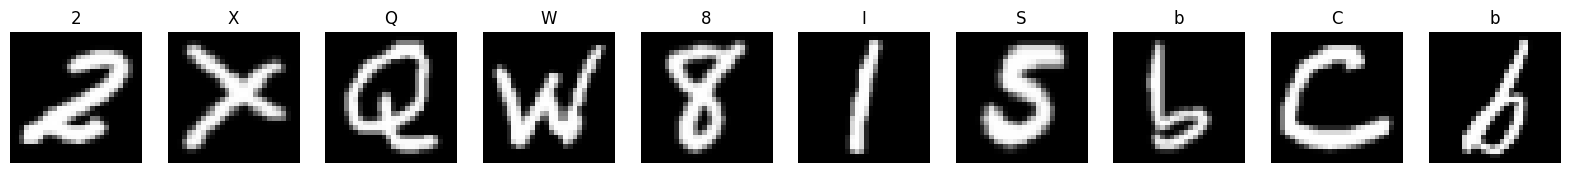

In [9]:
# Проверяем корректность изображений
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив

    # Убираем размерность канала (если она есть)
    if image_np.shape[0] == 1:  # Если канал один (черно-белое изображение)
        image_np = image_np.squeeze(0)  # Убираем размерность канала

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')
    axs[i].set_title(label_dict[label])  # Используем словарь для отображения метки
    axs[i].axis('off')

plt.show()


In [10]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

## Моделирование

Сверточная нейронная сеть (CNN)

In [12]:
# Определение модели
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Убедитесь в правильном размере
        self.fc2 = nn.Linear(128, 47)  # Для 47 классов

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
# Инициализация модели
model_cnn = CNNModel()

In [12]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [13]:
n_epochs = 10

for epoch in range(n_epochs):
    model_cnn.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 0.6164
Validation Accuracy: 0.8476
Epoch 2/10, Loss: 0.3942
Validation Accuracy: 0.8606
Epoch 3/10, Loss: 0.3456
Validation Accuracy: 0.8669
Epoch 4/10, Loss: 0.3131
Validation Accuracy: 0.8685
Epoch 5/10, Loss: 0.2871
Validation Accuracy: 0.8764
Epoch 6/10, Loss: 0.2653
Validation Accuracy: 0.8786
Epoch 7/10, Loss: 0.2461
Validation Accuracy: 0.8721
Epoch 8/10, Loss: 0.2279
Validation Accuracy: 0.8831
Epoch 9/10, Loss: 0.2115
Validation Accuracy: 0.8778
Epoch 10/10, Loss: 0.1964
Validation Accuracy: 0.8773


In [14]:
n_epoch = 10

In [15]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'data/model_a.ckpt')

# Сохранение обученной модели
checkpoint = {
    'model_state_dict': model_cnn.state_dict(),  # Состояние модели
    'optimizer_state_dict': optimizer.state_dict(),  # Состояние оптимизатора
    'epoch': n_epoch  # Текущий номер эпохи (если нужно возобновить обучение)
}

# Сохранение контрольной точки в файл .ckpt
torch.save(checkpoint, 'data/model_a_checkpoint.ckpt')

In [16]:
# Загрузка контрольной точки
checkpoint = torch.load('data/model_a_checkpoint.ckpt')

# Восстановление состояния модели и оптимизатора
model_cnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Если нужно, можно восстановить номер эпохи
n_epoch = checkpoint['epoch']
print(n_epoch)

# Восстановление номера эпохи
start_epoch = checkpoint['epoch'] + 1  # Начинаем с следующей эпохи

# Параметры для продолжения обучения
n_epochs_to_continue = 15  # Количество дополнительных эпох

# Загрузка предварительно обученной модели
model_cnn = CNNModel()  # Предполагается, что модель определена
model_cnn.load_state_dict(torch.load('data/model_a.ckpt'))  # Замените на путь к вашей модели
#model.eval()  # Установка модели в режим оценки

10


/tmp/ipykernel_5033/725509854.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model_a_checkpoint.ckpt')
/tmp/ipykernel_5033/725509854.py:20

<All keys matched successfully>

In [17]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0005)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [18]:
for epoch in range(start_epoch, start_epoch + n_epochs_to_continue):
    model_cnn.train()
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model_cnn(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch}/{start_epoch + n_epochs_to_continue}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 11/26, Loss: 0.1569
Validation Accuracy: 0.8753
Epoch 12/26, Loss: 0.1406
Validation Accuracy: 0.8781
Epoch 13/26, Loss: 0.1297
Validation Accuracy: 0.8781
Epoch 14/26, Loss: 0.1210
Validation Accuracy: 0.8771
Epoch 15/26, Loss: 0.1125
Validation Accuracy: 0.8744
Epoch 16/26, Loss: 0.1054
Validation Accuracy: 0.8705
Epoch 17/26, Loss: 0.0982
Validation Accuracy: 0.8731
Epoch 18/26, Loss: 0.0919
Validation Accuracy: 0.8677
Epoch 19/26, Loss: 0.0865
Validation Accuracy: 0.8683
Epoch 20/26, Loss: 0.0807
Validation Accuracy: 0.8684
Epoch 21/26, Loss: 0.0758
Validation Accuracy: 0.8684
Epoch 22/26, Loss: 0.0710
Validation Accuracy: 0.8650
Epoch 23/26, Loss: 0.0672
Validation Accuracy: 0.8674
Epoch 24/26, Loss: 0.0636
Validation Accuracy: 0.8660
Epoch 25/26, Loss: 0.0603
Validation Accuracy: 0.8679


In [19]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'data/model_a_1.ckpt')

# Сохранение обученной модели
new_checkpoint = {
    'model_state_dict': model_cnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': start_epoch + n_epochs_to_continue - 1,
}
# Сохранение контрольной точки в файл .ckpt
torch.save(new_checkpoint, 'data/model_a_checkpoint_1.ckpt')

In [20]:
# Загрузка контрольной точки
checkpoint = torch.load('data/model_a_checkpoint_1.ckpt')

# Восстановление состояния модели и оптимизатора
model_cnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Если нужно, можно восстановить номер эпохи
n_epoch = checkpoint['epoch']
print(n_epoch)

# Восстановление номера эпохи
start_epoch = checkpoint['epoch'] + 1  # Начинаем с следующей эпохи

# Параметры для продолжения обучения
n_epochs_to_continue = 5  # Количество дополнительных эпох

# Загрузка предварительно обученной модели
model_cnn = CNNModel()  # Предполагается, что модель определена
model_cnn.load_state_dict(torch.load('data/model_a_1.ckpt'))  # Замените на путь к вашей модели
#model.eval()  # Установка модели в режим оценки

25


/tmp/ipykernel_5033/178477228.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model_a_checkpoint_1.ckpt')
/tmp/ipykernel_5033/178477228.py:

<All keys matched successfully>

In [21]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.00001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [22]:
for epoch in range(start_epoch, start_epoch + n_epochs_to_continue):
    model_cnn.train()
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model_cnn(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch}/{start_epoch + n_epochs_to_continue}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 26/31, Loss: 0.0442
Validation Accuracy: 0.8689
Epoch 27/31, Loss: 0.0396
Validation Accuracy: 0.8697
Epoch 28/31, Loss: 0.0379
Validation Accuracy: 0.8693
Epoch 29/31, Loss: 0.0368
Validation Accuracy: 0.8702
Epoch 30/31, Loss: 0.0360
Validation Accuracy: 0.8695


In [23]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'data/model_a_2.ckpt')

# Сохранение обученной модели
new_checkpoint = {
    'model_state_dict': model_cnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': start_epoch + n_epochs_to_continue - 1,
}
# Сохранение контрольной точки в файл .ckpt
torch.save(new_checkpoint, 'data/model_a_checkpoint_2.ckpt')

# Дообучение на преобразованных данных

In [24]:
# Загрузка контрольной точки
checkpoint = torch.load('data/model_a_checkpoint_2.ckpt')

# Восстановление состояния модели и оптимизатора
model_cnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Если нужно, можно восстановить номер эпохи
n_epoch = checkpoint['epoch']
print(n_epoch)

# Восстановление номера эпохи
start_epoch = checkpoint['epoch'] + 1  # Начинаем с следующей эпохи

# Параметры для продолжения обучения
n_epochs_to_continue = 10  # Количество дополнительных эпох

# Загрузка предварительно обученной модели
model_cnn = CNNModel()  # Предполагается, что модель определена
model_cnn.load_state_dict(torch.load('data/model_a_2.ckpt'))  # Замените на путь к вашей модели
#model.eval()  # Установка модели в режим оценки

30


/tmp/ipykernel_5033/276588742.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model_a_checkpoint_2.ckpt')
/tmp/ipykernel_5033/276588742.py:

<All keys matched successfully>

In [25]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [26]:
'''Для обработки изображений х EMNIST с использованием методов Eroding, Dilating и Smoothing Images,
 создадим функцию, для предобработки перед передачей изображений в модель'''


def preprocess_image(img):
    # Преобразуем изображение PIL в массив NumPy
    img_np = np.array(img)

    # Применяем сглаживание (Gaussian Blur)
    img_blurred = cv2.GaussianBlur(img_np, (5, 5), 0)

    # Применяем эрозию
    kernel = np.ones((3, 3), np.uint8)
    img_eroded = cv2.erode(img_blurred, kernel, iterations=1)

    # Применяем дилатацию
    img_dilated = cv2.dilate(img_eroded, kernel, iterations=1)

    # Преобразуем обратно в PIL
    img_processed = Image.fromarray(img_dilated)

    return img_processed

In [27]:
# Определение трансформаций для нормализации данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Нормализация по среднему и стандартному отклонению
])

# использованием методов Eroding, Dilating и Smoothing Images
# Загрузка обучающего набора данных с трансформациями
train_data = EMNIST('data_e_r/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ 
                    # Применяем обработку изображения
                    preprocess_image,
                    # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

# использованием методов Eroding, Dilating и Smoothing Images
# Загрузка тестового набора данных с трансформациями
test_data = EMNIST('data_e_r/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ 
                    # Применяем обработку изображения
                    preprocess_image,
                    # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

In [28]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [29]:
for epoch in range(start_epoch, start_epoch + n_epochs_to_continue):
    model_cnn.train()
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model_cnn(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch}/{start_epoch + n_epochs_to_continue}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 31/41, Loss: 0.3349
Validation Accuracy: 0.8680
Epoch 32/41, Loss: 0.2468
Validation Accuracy: 0.8670
Epoch 33/41, Loss: 0.2161
Validation Accuracy: 0.8694
Epoch 34/41, Loss: 0.1967
Validation Accuracy: 0.8677
Epoch 35/41, Loss: 0.1793
Validation Accuracy: 0.8685
Epoch 36/41, Loss: 0.1650
Validation Accuracy: 0.8693
Epoch 37/41, Loss: 0.1539
Validation Accuracy: 0.8661
Epoch 38/41, Loss: 0.1432
Validation Accuracy: 0.8712
Epoch 39/41, Loss: 0.1340
Validation Accuracy: 0.8651
Epoch 40/41, Loss: 0.1259
Validation Accuracy: 0.8661


In [30]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'data/model_a_3.ckpt')

# Сохранение обученной модели
new_checkpoint = {
    'model_state_dict': model_cnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': start_epoch + n_epochs_to_continue - 1,
}
# Сохранение контрольной точки в файл .ckpt
torch.save(new_checkpoint, 'data/model_a_checkpoint_3.ckpt')

Первый этап (начальное обучение):

    Скорость обучения: Начните с более высокой скорости обучения, например, 0.001. Это поможет модели быстро адаптироваться к данным.
    Количество эпох: Используйте большее количество эпох (например, 10-20), чтобы модель могла хорошо обучиться на данных.

Второй этап (дообучение):

    Скорость обучения: Уменьшите скорость обучения до 0.0005 или 0.0001. Это позволит модели более точно подстраиваться под данные.
    Количество эпох: Увеличьте количество эпох (например, 20-30), чтобы модель могла дообучиться на более низкой скорости.

Третий этап (файн-тюнинг):

    Скорость обучения: Установите еще более низкую скорость обучения (например, 0.00001). Это позволит модели делать очень мелкие корректировки.
    Количество эпох: Используйте меньшее количество эпох (например, 5-10), так как модель уже близка к оптимальному состоянию.


In [31]:
# Загрузка контрольной точки
checkpoint = torch.load('data/model_a_checkpoint_3.ckpt')

# Восстановление состояния модели и оптимизатора
model_cnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Если нужно, можно восстановить номер эпохи
n_epoch = checkpoint['epoch']
print(n_epoch)

# Восстановление номера эпохи
start_epoch = checkpoint['epoch'] + 1  # Начинаем с следующей эпохи

# Параметры для продолжения обучения
n_epochs_to_continue = 15  # Количество дополнительных эпох

# Загрузка предварительно обученной модели
model_cnn = CNNModel()  # Предполагается, что модель определена
model_cnn.load_state_dict(torch.load('data/model_a_3.ckpt'))  # Замените на путь к вашей модели
#model.eval()  # Установка модели в режим оценки

40


/tmp/ipykernel_5033/131934471.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model_a_checkpoint_3.ckpt')
/tmp/ipykernel_5033/131934471.py:

<All keys matched successfully>

In [32]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [33]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [34]:
for epoch in range(start_epoch, start_epoch + n_epochs_to_continue):
    model_cnn.train()
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model_cnn(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch}/{start_epoch + n_epochs_to_continue}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 41/56, Loss: 0.0831
Validation Accuracy: 0.8719
Epoch 42/56, Loss: 0.0727
Validation Accuracy: 0.8713
Epoch 43/56, Loss: 0.0681
Validation Accuracy: 0.8726
Epoch 44/56, Loss: 0.0650
Validation Accuracy: 0.8709
Epoch 45/56, Loss: 0.0620
Validation Accuracy: 0.8719
Epoch 46/56, Loss: 0.0596
Validation Accuracy: 0.8705
Epoch 47/56, Loss: 0.0572
Validation Accuracy: 0.8713
Epoch 48/56, Loss: 0.0550
Validation Accuracy: 0.8692
Epoch 49/56, Loss: 0.0530
Validation Accuracy: 0.8703
Epoch 50/56, Loss: 0.0511
Validation Accuracy: 0.8684
Epoch 51/56, Loss: 0.0493
Validation Accuracy: 0.8700
Epoch 52/56, Loss: 0.0475
Validation Accuracy: 0.8682
Epoch 53/56, Loss: 0.0462
Validation Accuracy: 0.8665
Epoch 54/56, Loss: 0.0445
Validation Accuracy: 0.8693
Epoch 55/56, Loss: 0.0429
Validation Accuracy: 0.8679


In [35]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'data/model_a_4.ckpt')

# Сохранение обученной модели
new_checkpoint = {
    'model_state_dict': model_cnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': start_epoch + n_epochs_to_continue - 1,
}
# Сохранение контрольной точки в файл .ckpt
torch.save(new_checkpoint, 'data/model_a_checkpoint_4.ckpt')

In [36]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.00001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [37]:
# Загрузка контрольной точки
checkpoint = torch.load('data/model_a_checkpoint_4.ckpt')

# Восстановление состояния модели и оптимизатора
model_cnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Если нужно, можно восстановить номер эпохи
n_epoch = checkpoint['epoch']
print(n_epoch)

# Восстановление номера эпохи
start_epoch = checkpoint['epoch'] + 1  # Начинаем с следующей эпохи

# Параметры для продолжения обучения
n_epochs_to_continue = 5  # Количество дополнительных эпох

# Загрузка предварительно обученной модели
model_cnn = CNNModel()  # Предполагается, что модель определена
model_cnn.load_state_dict(torch.load('data/model_a_4.ckpt'))  # Замените на путь к вашей модели
#model.eval()  # Установка модели в режим оценки

55


/tmp/ipykernel_5033/114102098.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model_a_checkpoint_4.ckpt')
/tmp/ipykernel_5033/114102098.py:

<All keys matched successfully>

In [38]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [39]:
for epoch in range(start_epoch, start_epoch + n_epochs_to_continue):
    model_cnn.train()
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model_cnn(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch}/{start_epoch + n_epochs_to_continue}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 56/61, Loss: 0.0400
Validation Accuracy: 0.8680
Epoch 57/61, Loss: 0.0399
Validation Accuracy: 0.8676
Epoch 58/61, Loss: 0.0400
Validation Accuracy: 0.8679
Epoch 59/61, Loss: 0.0401
Validation Accuracy: 0.8676
Epoch 60/61, Loss: 0.0400
Validation Accuracy: 0.8676


In [40]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'data/model_a_5.ckpt')

# Сохранение обученной модели
new_checkpoint = {
    'model_state_dict': model_cnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': start_epoch + n_epochs_to_continue - 1,
}
# Сохранение контрольной точки в файл .ckpt
torch.save(new_checkpoint, 'data/model_a_checkpoint_5.ckpt')

# Оценка модели

In [17]:
model_cnn = CNNModel() 
optimizer = optim.Adam(model_cnn.parameters(), lr=0.00001) 

# Загрузка контрольной точки
checkpoint = torch.load('data/model_a_checkpoint_5.ckpt')

# Восстановление состояния модели и оптимизатора
model_cnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Если нужно, можно восстановить номер эпохи
n_epoch = checkpoint['epoch']
print('epoches', n_epoch)

# Восстановление номера эпохи
start_epoch = checkpoint['epoch'] + 1  # Начинаем с следующей эпохи

# Параметры для продолжения обучения
n_epochs_to_continue = 5  # Количество дополнительных эпох

# Загрузка предварительно обученной модели
model_cnn = CNNModel()  # Предполагается, что модель определена
model_cnn.load_state_dict(torch.load('data/model_a_5.ckpt'))  # Замените на путь к вашей модели
#model.eval()  # Установка модели в режим оценки

epoches 60


/tmp/ipykernel_5215/1368578123.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model_a_checkpoint_5.ckpt')
/tmp/ipykernel_5215/1368578123.p

<All keys matched successfully>

In [42]:

# Инициализация переменных для хранения результатов
class_correct = [0] * 47  # Для каждого из 47 классов
class_total = [0] * 47

# Оценка модели на тестовом наборе данных
with torch.no_grad():
    for data, target in val_loader:
        output = model_cnn(data)  # Получение предсказаний от модели
        _, predicted = torch.max(output, 1)  # Получение индексов классов с максимальным значением вероятности

        # Подсчет правильных предсказаний для каждого класса
        for i in range(len(target)):
            label = target[i].item()  # Получение метки класса
            class_correct[label] += (predicted[i] == label).item()  # Увеличение счетчика для правильного предсказания
            class_total[label] += 1  # Увеличение общего количества примеров для данного класса

# Вывод результатов по каждому классу
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        print(label_dict[i])
        print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

0
Accuracy of class 0: 0.67
1
Accuracy of class 1: 0.58
2
Accuracy of class 2: 0.87
3
Accuracy of class 3: 0.97
4
Accuracy of class 4: 0.92
5
Accuracy of class 5: 0.90
6
Accuracy of class 6: 0.93
7
Accuracy of class 7: 0.97
8
Accuracy of class 8: 0.94
9
Accuracy of class 9: 0.73
A
Accuracy of class 10: 0.95
B
Accuracy of class 11: 0.95
C
Accuracy of class 12: 0.94
D
Accuracy of class 13: 0.91
E
Accuracy of class 14: 0.97
F
Accuracy of class 15: 0.65
G
Accuracy of class 16: 0.92
H
Accuracy of class 17: 0.96
I
Accuracy of class 18: 0.60
J
Accuracy of class 19: 0.93
K
Accuracy of class 20: 0.96
L
Accuracy of class 21: 0.56
M
Accuracy of class 22: 0.96
N
Accuracy of class 23: 0.94
O
Accuracy of class 24: 0.64
P
Accuracy of class 25: 0.96
Q
Accuracy of class 26: 0.93
R
Accuracy of class 27: 0.96
S
Accuracy of class 28: 0.91
T
Accuracy of class 29: 0.92
U
Accuracy of class 30: 0.91
V
Accuracy of class 31: 0.93
W
Accuracy of class 32: 0.99
X
Accuracy of class 33: 0.95
Y
Accuracy of class 34: 

In [43]:
# Вывод результатов по каждому классу с accuracy < 0.87
print("Classes with accuracy < 0.87:")
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        if accuracy < 0.87:  # Проверяем условие на точность
            print(label_dict[i])  # Выводим метку класса
            print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

Classes with accuracy < 0.87:
0
Accuracy of class 0: 0.67
1
Accuracy of class 1: 0.58
9
Accuracy of class 9: 0.73
F
Accuracy of class 15: 0.65
I
Accuracy of class 18: 0.60
L
Accuracy of class 21: 0.56
O
Accuracy of class 24: 0.64
f
Accuracy of class 40: 0.56
g
Accuracy of class 41: 0.65
q
Accuracy of class 44: 0.59


In [16]:
# Вывод информации о модели
summary(model_cnn, input_size=(1, 1, 28, 28))  # Указываем размер входного тензора [batch_size, channels, height, width]

[W107 10:55:10.689273856 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 47]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Linear: 1-7                            [1, 128]                  401,536
├─Linear: 1-8                            [1, 47]                   6,063
Total params: 426,607
Trainable params: 426,607
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.60
Params size (MB): 1.71
Estimated Total Size (MB): 2.31

## Оценка модели на разных типах данных

### Отражение и поворот

In [31]:
# Определение трансформаций для нормализации данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Нормализация по среднему и стандартному отклонению
])

# Загрузка обучающего набора данных с трансформациями
train_data = EMNIST('data_c/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))


# Загрузка тестового набора данных с трансформациями
test_data = EMNIST('data_c/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

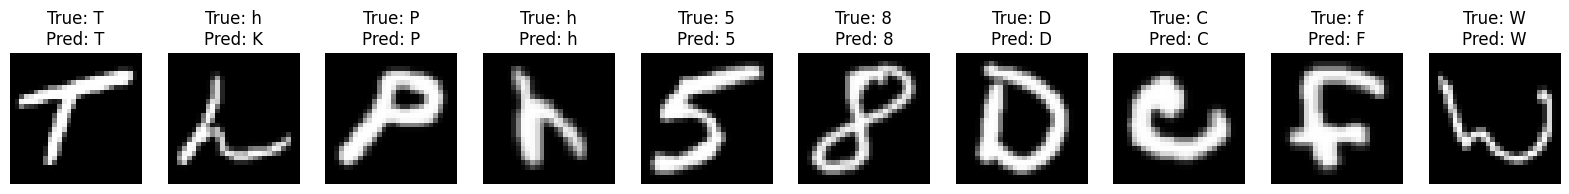

In [32]:
def predict(image):
    # Применяем преобразования к изображению, если они требуются
    # image = transform(input_image)  # Примените необходимые преобразования
    # Убедитесь, что изображение имеет форму (1, 1, H, W) для модели
    if image.dim() == 2:  # Если изображение 2D (H, W)
        image = image.unsqueeze(0)  # Добавляем размер канала
    image = image.unsqueeze(0)  # Добавляем размер батча

    #print('image shape:', image.shape)

    with torch.no_grad():  # Отключаем градиенты для повышения производительности
        output = model_cnn(image)  # Получаем выход модели
        _, predicted_class = torch.max(output.data, 1)  # Находим класс с максимальной вероятностью
        predicted_label = predicted_class.item()  # Получаем метку класса как целое число
        #print('predicted_label:', predicted_label)

        pred = label_dict[predicted_label]  # Получаем предсказанную метку
        #print('predicted symbol:', pred)

    return pred

# Проверяем предсказания
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.squeeze(0).numpy()  # Убираем размер канала и преобразуем в NumPy массив

    pred = predict(image)  # Предсказание для изображения

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')  # Используем cmap='gray' для черно-белых изображений
    # Добавляем отображение истинной метки и предсказанного значения
    axs[i].set_title(f'True: {label_dict[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()


In [33]:
def evaluate_model(model, test_loader):
    model.eval()  # Устанавливаем модель в режим оценки
    criterion = nn.CrossEntropyLoss()  # Функция потерь
    total_loss = 0.0
    correct = 0
    class_correct = [0] * 47  # Для каждого из 47 классов
    class_total = [0] * 47

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)  # Получаем предсказания от модели
            
            # Вычисление потерь
            loss = criterion(output, target)
            total_loss += loss.item()

            # Получение предсказаний
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

            # Подсчет правильных предсказаний для каждого класса
            for i in range(len(target)):
                label = target[i].item()  # Получаем метку класса
                class_correct[label] += (pred[i] == label).item()  # Увеличиваем счетчик для правильного предсказания
                class_total[label] += 1  # Увеличиваем общее количество примеров для данного класса

    # Вычисляем общую точность и среднюю потерю
    accuracy = correct / len(test_loader.dataset)
    average_loss = total_loss / len(test_loader)

    print(f'Overall Accuracy: {accuracy:.4f}')
    print(f'Average Loss: {average_loss:.4f}')

    # Вывод результатов по каждому классу
    for i in range(47):
        if class_total[i] > 0:  # Избегаем деления на ноль
            class_accuracy = class_correct[i] / class_total[i]
            #print(f'Accuracy of class {i}: {class_accuracy:.2f}')
        else:
            print(f'Class {i} has no samples in the test set.')

In [34]:
evaluate_model(model_cnn, val_loader)

Overall Accuracy: 0.7936
Average Loss: 2.1104


### Отражение, поворот, дилатация, эррозия

In [35]:
'''Для обработки изображений х EMNIST с использованием методов Eroding, Dilating и Smoothing Images, 
 создадим функцию, для предобработки перед передачей изображений в модель'''


def preprocess_image(img):
    # Преобразуем изображение PIL в массив NumPy
    img_np = np.array(img)

    # Применяем сглаживание (Gaussian Blur)
    img_blurred = cv2.GaussianBlur(img_np, (5, 5), 0)

    # Применяем эрозию
    kernel = np.ones((3, 3), np.uint8)
    img_eroded = cv2.erode(img_blurred, kernel, iterations=1)

    # Применяем дилатацию
    img_dilated = cv2.dilate(img_eroded, kernel, iterations=1)

    # Преобразуем обратно в PIL
    img_processed = Image.fromarray(img_dilated)

    return img_processed

In [36]:
# использованием методов Eroding, Dilating и Smoothing Images
# Загрузка обучающего набора данных с трансформациями
train_data = EMNIST('data_e_r/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ 
                    # Применяем обработку изображения
                    preprocess_image,
                    # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

# использованием методов Eroding, Dilating и Smoothing Images
# Загрузка тестового набора данных с трансформациями
test_data = EMNIST('data_e_r/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ 
                    # Применяем обработку изображения
                    preprocess_image,
                    # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

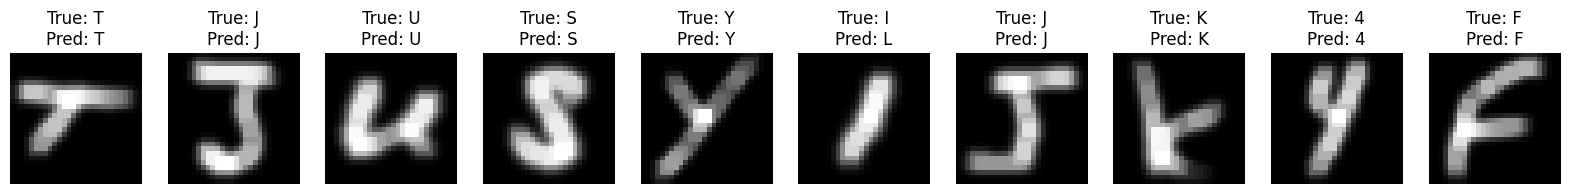

In [37]:
def predict(image):
    # Применяем преобразования к изображению, если они требуются
    # image = transform(input_image)  # Примените необходимые преобразования
    # Убедитесь, что изображение имеет форму (1, 1, H, W) для модели
    if image.dim() == 2:  # Если изображение 2D (H, W)
        image = image.unsqueeze(0)  # Добавляем размер канала
    image = image.unsqueeze(0)  # Добавляем размер батча

    #print('image shape:', image.shape)

    with torch.no_grad():  # Отключаем градиенты для повышения производительности
        output = model_cnn(image)  # Получаем выход модели
        _, predicted_class = torch.max(output.data, 1)  # Находим класс с максимальной вероятностью
        predicted_label = predicted_class.item()  # Получаем метку класса как целое число
        #print('predicted_label:', predicted_label)

        pred = label_dict[predicted_label]  # Получаем предсказанную метку
        #print('predicted symbol:', pred)

    return pred

# Проверяем предсказания
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.squeeze(0).numpy()  # Убираем размер канала и преобразуем в NumPy массив

    pred = predict(image)  # Предсказание для изображения

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')  # Используем cmap='gray' для черно-белых изображений
    # Добавляем отображение истинной метки и предсказанного значения
    axs[i].set_title(f'True: {label_dict[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()


In [38]:
def evaluate_model(model, test_loader):
    model.eval()  # Устанавливаем модель в режим оценки
    criterion = nn.CrossEntropyLoss()  # Функция потерь
    total_loss = 0.0
    correct = 0
    class_correct = [0] * 47  # Для каждого из 47 классов
    class_total = [0] * 47

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)  # Получаем предсказания от модели
            
            # Вычисление потерь
            loss = criterion(output, target)
            total_loss += loss.item()

            # Получение предсказаний
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

            # Подсчет правильных предсказаний для каждого класса
            for i in range(len(target)):
                label = target[i].item()  # Получаем метку класса
                class_correct[label] += (pred[i] == label).item()  # Увеличиваем счетчик для правильного предсказания
                class_total[label] += 1  # Увеличиваем общее количество примеров для данного класса

    # Вычисляем общую точность и среднюю потерю
    accuracy = correct / len(test_loader.dataset)
    average_loss = total_loss / len(test_loader)

    print(f'Overall Accuracy: {accuracy:.4f}')
    print(f'Average Loss: {average_loss:.4f}')

    # Вывод результатов по каждому классу
    for i in range(47):
        if class_total[i] > 0:  # Избегаем деления на ноль
            class_accuracy = class_correct[i] / class_total[i]
            #print(f'Accuracy of class {i}: {class_accuracy:.2f}')
        else:
            print(f'Class {i} has no samples in the test set.')

In [39]:
evaluate_model(model_cnn, val_loader)

Overall Accuracy: 0.8255
Average Loss: 0.5957


### Первоначальная модель после первого этапа обучения

In [40]:
# Определение трансформаций для нормализации данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Нормализация по среднему и стандартному отклонению
])

# Загрузка обучающего набора данных с трансформациями
train_data = EMNIST('data_c/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))


# Загрузка тестового набора данных с трансформациями
test_data = EMNIST('data_c/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [41]:
# Загрузка модели
model_cnn = CNNModel() 
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001) 

# Загрузка контрольной точки
checkpoint = torch.load('data/model_a_checkpoint.ckpt')

# Восстановление состояния модели и оптимизатора
model_cnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Если нужно, можно восстановить номер эпохи
n_epoch = checkpoint['epoch']
print('epoches', n_epoch)

# Восстановление номера эпохи
start_epoch = checkpoint['epoch'] + 1  # Начинаем с следующей эпохи

# Параметры для продолжения обучения
n_epochs_to_continue = 5  # Количество дополнительных эпох

# Загрузка предварительно обученной модели
model_cnn = CNNModel()  # Предполагается, что модель определена
model_cnn.load_state_dict(torch.load('data/model_a.ckpt'))  # Замените на путь к вашей модели
#model.eval()  # Установка модели в режим оценки

epoches 10


/tmp/ipykernel_5215/1202297313.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model_a_checkpoint.ckpt')
/tmp/ipykernel_5215/1202297313.py:

<All keys matched successfully>

In [43]:

# Инициализация переменных для хранения результатов
class_correct = [0] * 47  # Для каждого из 47 классов
class_total = [0] * 47

# Оценка модели на тестовом наборе данных
with torch.no_grad():
    for data, target in val_loader:
        output = model_cnn(data)  # Получение предсказаний от модели
        _, predicted = torch.max(output, 1)  # Получение индексов классов с максимальным значением вероятности

        # Подсчет правильных предсказаний для каждого класса
        for i in range(len(target)):
            label = target[i].item()  # Получение метки класса
            class_correct[label] += (predicted[i] == label).item()  # Увеличение счетчика для правильного предсказания
            class_total[label] += 1  # Увеличение общего количества примеров для данного класса


# Вывод результатов по каждому классу с accuracy < 0.87
print("Classes with accuracy < 0.87:")
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        if accuracy < 0.87:  # Проверяем условие на точность
            print(label_dict[i])  # Выводим метку класса
            print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

Classes with accuracy < 0.87:
0
Accuracy of class 0: 0.67
1
Accuracy of class 1: 0.81
9
Accuracy of class 9: 0.81
F
Accuracy of class 15: 0.67
I
Accuracy of class 18: 0.61
L
Accuracy of class 21: 0.41
O
Accuracy of class 24: 0.67
Y
Accuracy of class 34: 0.86
f
Accuracy of class 40: 0.63
g
Accuracy of class 41: 0.68
q
Accuracy of class 44: 0.50


In [42]:
evaluate_model(model_cnn, val_loader)

Overall Accuracy: 0.8773
Average Loss: 0.3945


# Выводы о проделаной работе:

### Негативные последствия излишней сложности модели, лишнего количества эпох обучения и лишних этапов дообучения

В машинном обучении, особенно в контексте глубокого обучения с использованием PyTorch, важно правильно настраивать архитектуру модели и параметры обучения. Излишняя сложность модели, слишком большое количество эпох и лишние этапы дообучения могут привести к ряду негативных последствий.

#### 1. Излишняя сложность модели на простых данных

**Проблема**: Если модель слишком сложная (например, содержит слишком много слоев или параметров) для простых данных, это может привести к переобучению.

**Негативные последствия**:
- **Переобучение**: Модель начинает "запоминать" обучающие данные вместо того, чтобы обобщать на новые данные. Это означает, что она будет показывать высокую точность на обучающем наборе, но низкую точность на валидационном или тестовом наборе.
- **Увеличение времени обучения**: Сложные модели требуют больше времени на обучение из-за большого количества параметров.
- **Сложность интерпретации**: Более сложные модели труднее интерпретировать и отлаживать, что может затруднить выявление проблем.

#### 2. Лишнее количество эпох обучения

**Проблема**: Если модель обучается слишком долго (больше необходимого количества эпох), это также может привести к переобучению.

**Негативные последствия**:
- **Переобучение**: Как и в случае с излишней сложностью модели, избыточное обучение приводит к тому, что модель начинает подстраиваться под шум в данных, что ухудшает её способность обобщать.
- **Неэффективное использование ресурсов**: Длительное обучение требует больше вычислительных ресурсов и времени, что может быть нецелесообразно.
- **Сложности с мониторингом метрик**: При длительном обучении может быть сложно отслеживать метрики валидации и вовремя остановить обучение.

#### 3. Лишние этапы дообучения модели

**Проблема**: Использование слишком большого количества этапов дообучения может привести к тому же эффекту переобучения.

**Негативные последствия**:
- **Неоптимальные результаты**: Каждый дополнительный этап дообучения увеличивает риск того, что модель начнет терять обобщающую способность.
- **Сложности с настройкой гиперпараметров**: При каждом новом этапе дообучения могут потребоваться новые настройки гиперпараметров (например, скорость обучения), что усложняет процесс обучения.
- **Увеличение времени до достижения результата**: Лишние этапы могут замедлить процесс получения окончательных результатов.

### Рекомендации по предотвращению негативных последствий

1. **Используйте простые модели для простых задач**: Начинайте с простой архитектуры и постепенно увеличивайте её сложность только при необходимости.
2. **Мониторинг метрик валидации**: Используйте методы ранней остановки (early stopping), чтобы прекратить обучение, когда валидационная точность перестает улучшаться.
3. **Регуляризация**: Применяйте методы регуляризации, такие как дропаут или L2-регуляризация, чтобы предотвратить переобучение.
4. **Аугментация данных**: Увеличьте объем данных с помощью аугментации, чтобы модель могла лучше обобщать.
5. **Оптимизация гиперпараметров**: Используйте автоматизированные методы подбора гиперпараметров для нахождения оптимальных значений.



## Итог

В качестве базовой модели для сериса выберем модель после первого этапа обучения с десятью эпохаим c lr==0.001

In [44]:
evaluate_model(model_cnn, val_loader)

Overall Accuracy: 0.8773
Average Loss: 0.3945


## Заключение

Правильная настройка архитектуры модели и параметров обучения критически важна для достижения хороших результатов в задачах машинного обучения. Избегайте излишней сложности модели, лишнего количества эпох и ненужных этапов дообучения для повышения производительности вашей модели на новых данных.